# Environment

In [1]:
import torchaudio
import numpy as np
from torch import Tensor
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.signal import find_peaks
from helpers.path_utils import get_base_dir
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks, decimate
from helpers.plot import plot_wavelet_spectrogram, plot_audio_fft
from helpers.audio_utils import apply_bandpass_filter, min_max_scale

# Raw Heartbeat

Sample rate:  22050


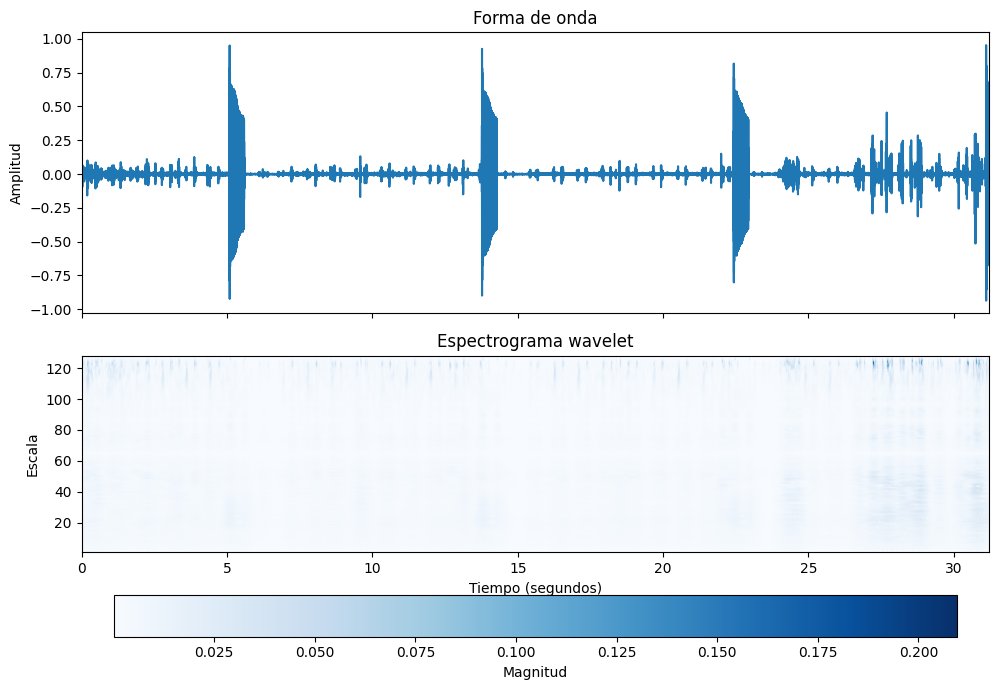

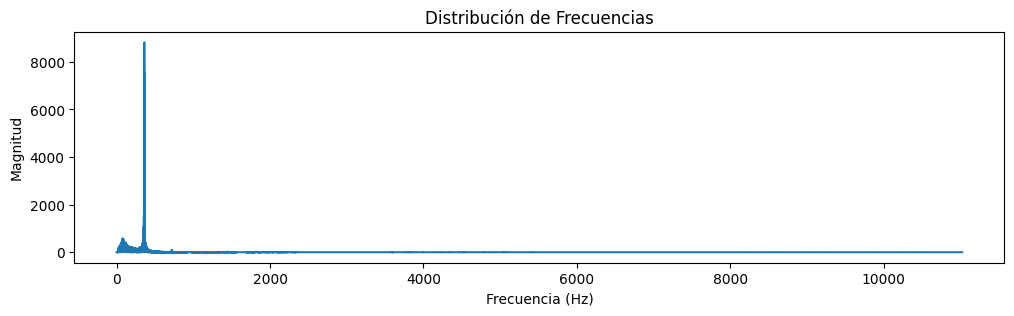

In [2]:
AUDIO_NAME = "test-20240902-1554.wav"
audio_dir = get_base_dir().joinpath("data", "mobile", "test", AUDIO_NAME)

audio, sample_rate = torchaudio.load(str(audio_dir))
print("Sample rate: ", sample_rate)

plot_wavelet_spectrogram(audio.numpy(), sample_rate)  # , downsample_factor=1)
plot_audio_fft(audio.numpy(), sample_rate)

Audio(audio, rate=sample_rate, autoplay=True)

# Resample to match the digital stethoscope sample rate

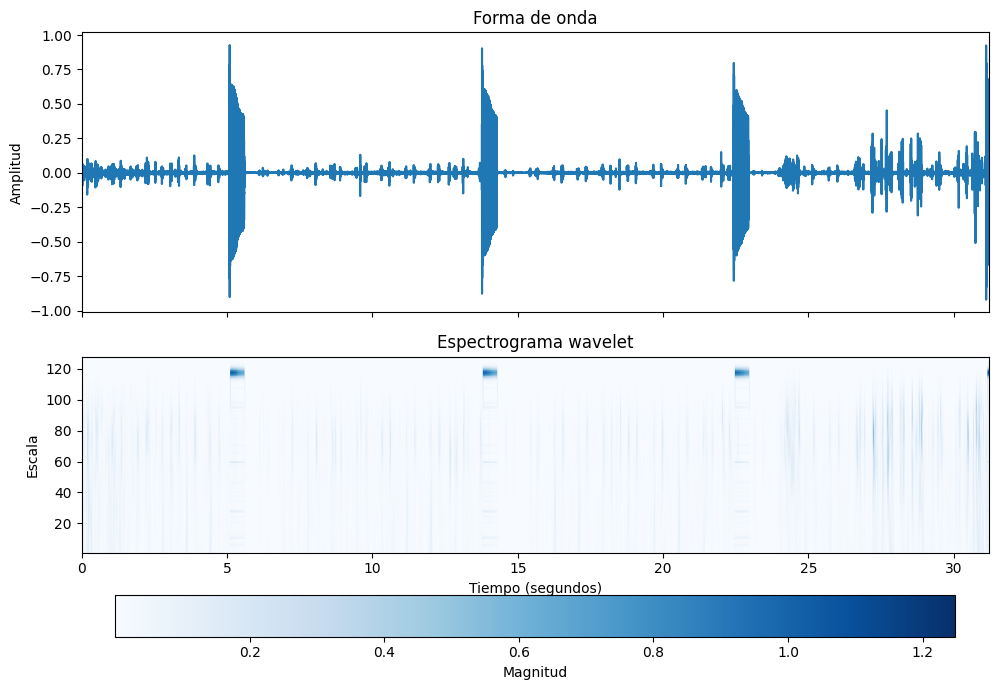

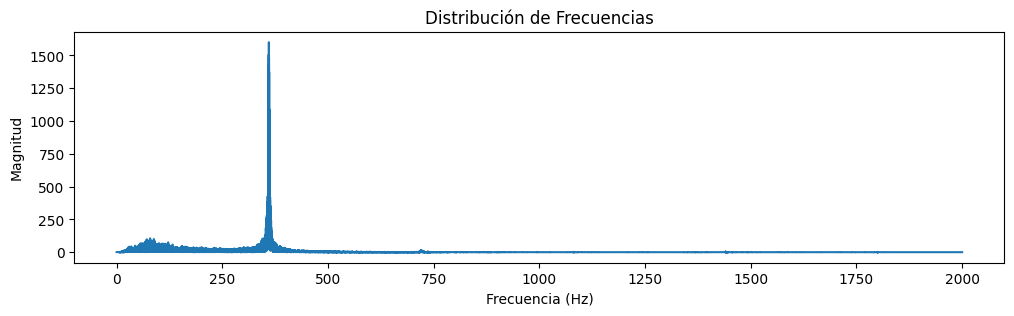

In [3]:
new_sample_rate = 4000

resampler = torchaudio.transforms.Resample(
    orig_freq=sample_rate, new_freq=new_sample_rate
)

audio = resampler(audio)
sample_rate = new_sample_rate

plot_wavelet_spectrogram(audio.numpy(), sample_rate, downsample_factor=1)
plot_audio_fft(audio.numpy(), sample_rate)

Audio(audio, rate=sample_rate, autoplay=True)

# Focus on synthetic frequency

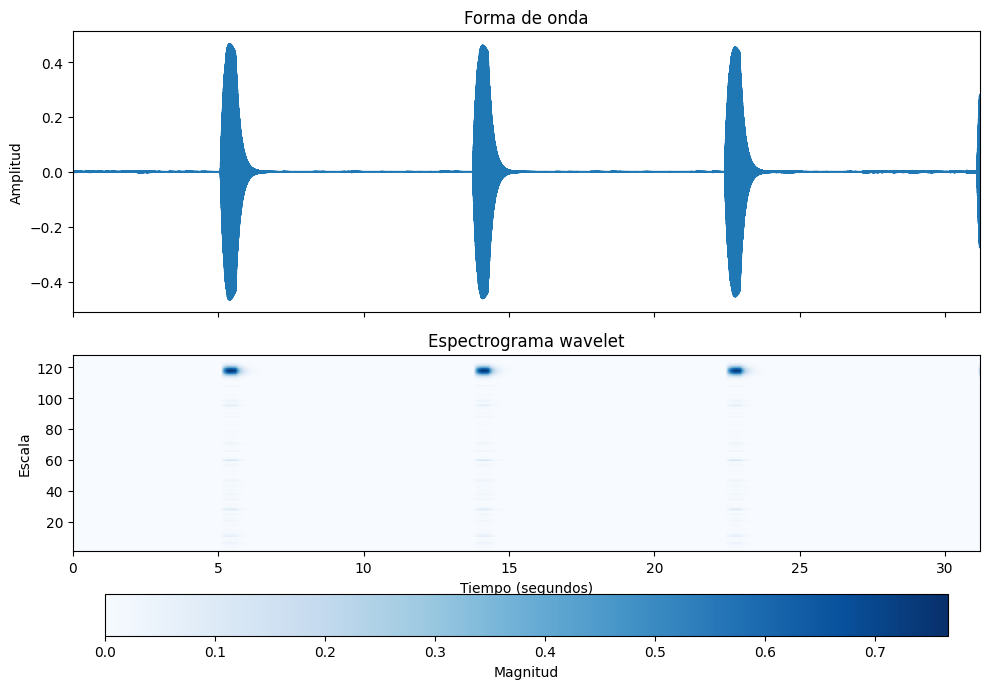

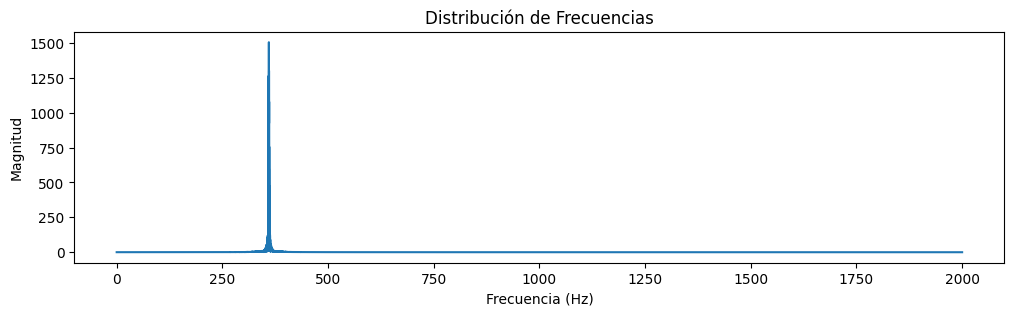

In [4]:
SYNTHETIC_FREQ = 360
low_cutoff = SYNTHETIC_FREQ - 1
high_cutoff = SYNTHETIC_FREQ + 1

filtered_audio = apply_bandpass_filter(audio, sample_rate, low_cutoff, high_cutoff)

plot_wavelet_spectrogram(filtered_audio.numpy(), sample_rate, downsample_factor=1)
plot_audio_fft(filtered_audio.numpy(), sample_rate)

Audio(filtered_audio, rate=sample_rate, autoplay=True)

# Absolute signal

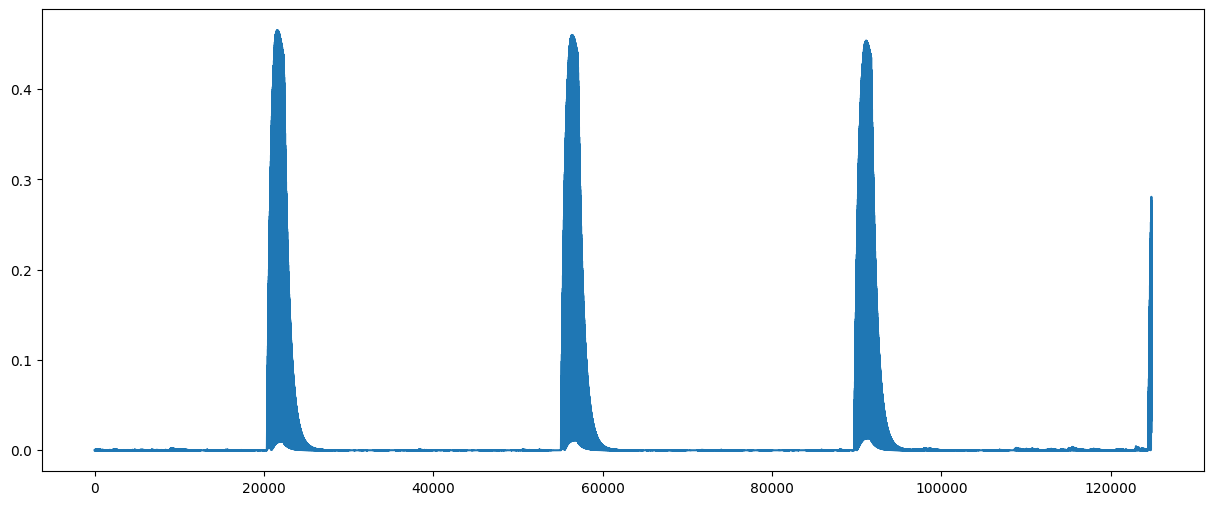

In [5]:
abs_filtered = filtered_audio.abs()

plt.figure(figsize=(15, 6))
plt.plot(abs_filtered.squeeze())

# Downsample it

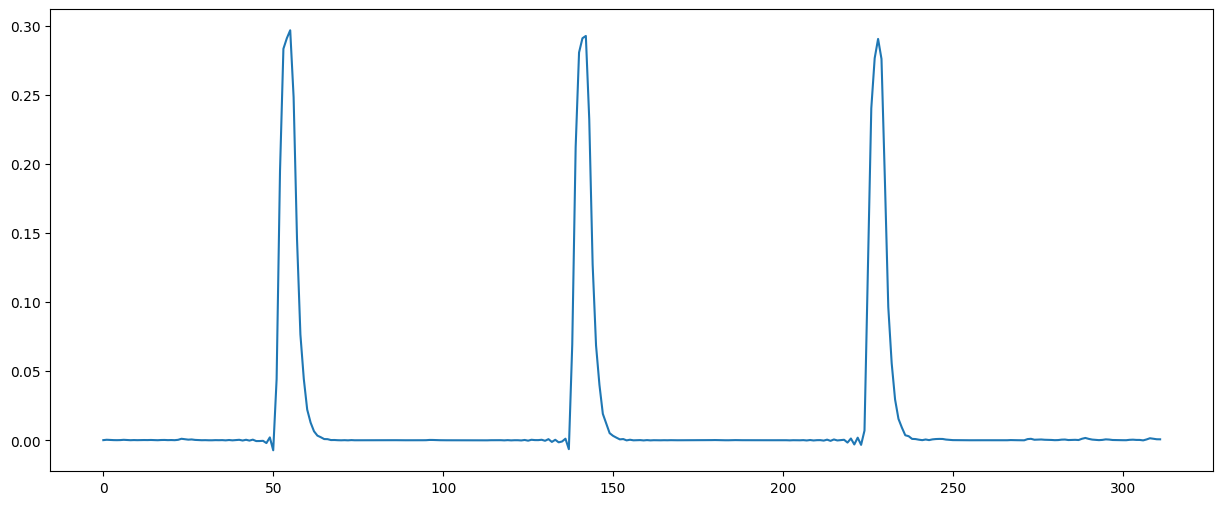

In [6]:
DOWNSAMPLE_FACTOR = 400

downsampled = decimate(abs_filtered, DOWNSAMPLE_FACTOR)

plt.figure(figsize=(15, 6))
plt.plot(downsampled.squeeze())

# Smooth it

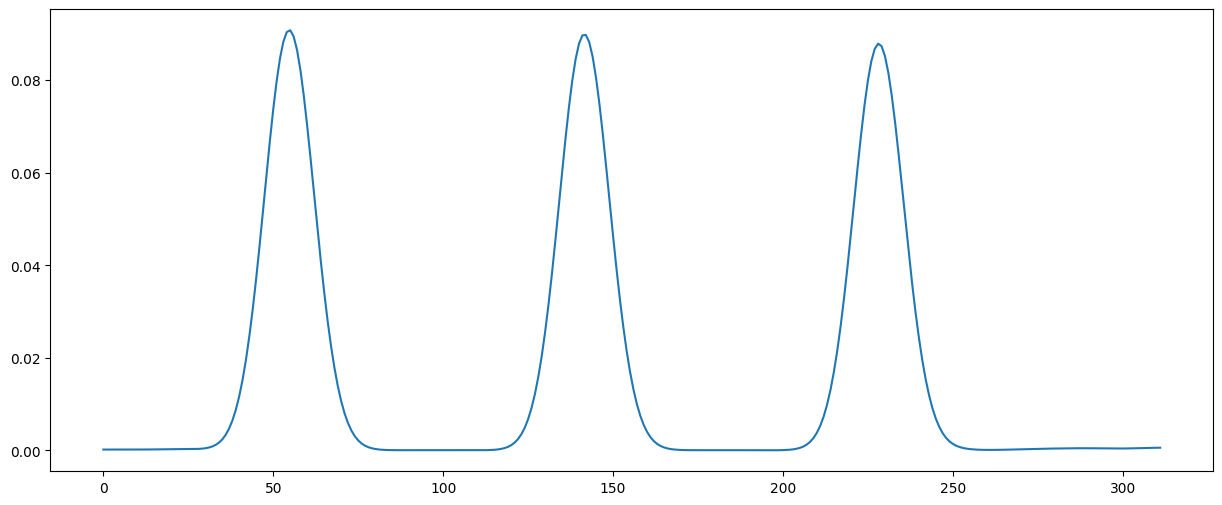

In [7]:
SIGMA_SMOOTH = 7

smoothed = gaussian_filter1d(downsampled, sigma=SIGMA_SMOOTH)

plt.figure(figsize=(15, 6))
plt.plot(smoothed.squeeze())

# Find peaks where signal changes

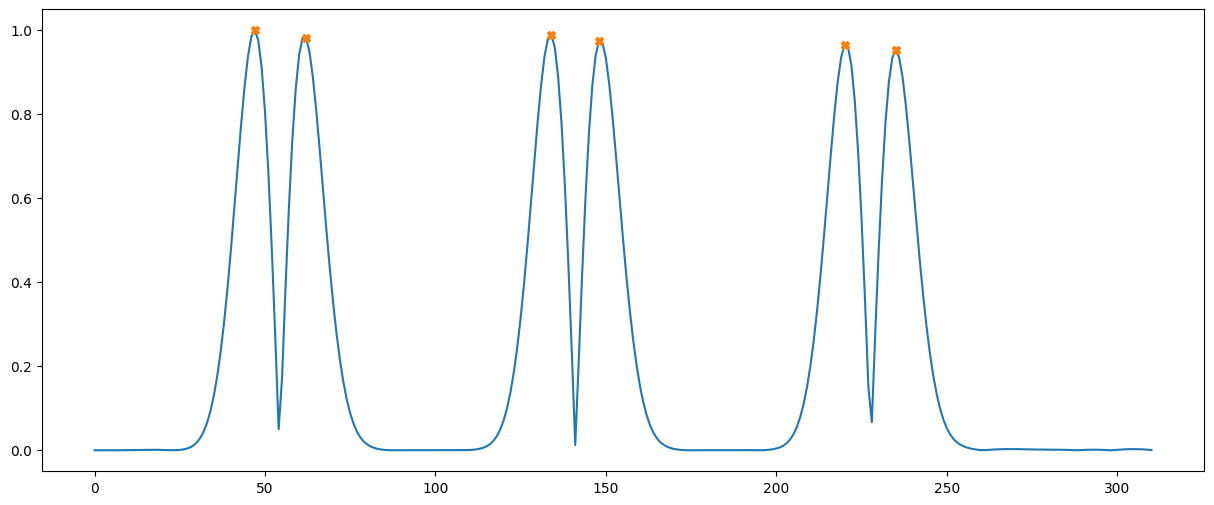

In [8]:
PEAKS_HEIGHT = 0.3
PEAKS_PROMINENCE = 0.0001

smoothed_diff = np.abs(np.diff(smoothed).squeeze())
smoothed_diff = min_max_scale(Tensor(smoothed_diff))
peaks, _ = find_peaks(smoothed_diff, height=PEAKS_HEIGHT, prominence=PEAKS_PROMINENCE)

plt.figure(figsize=(15, 6))
plt.plot(smoothed_diff)
plt.plot(peaks, smoothed_diff[peaks], "X")

# Upsample those peaks in the raw audio signal

Peaks found in downsampled signal: [ 47  62 134 148 220 235]
Peaks in real signal: [18800 24800 53600 59200 88000 94000]


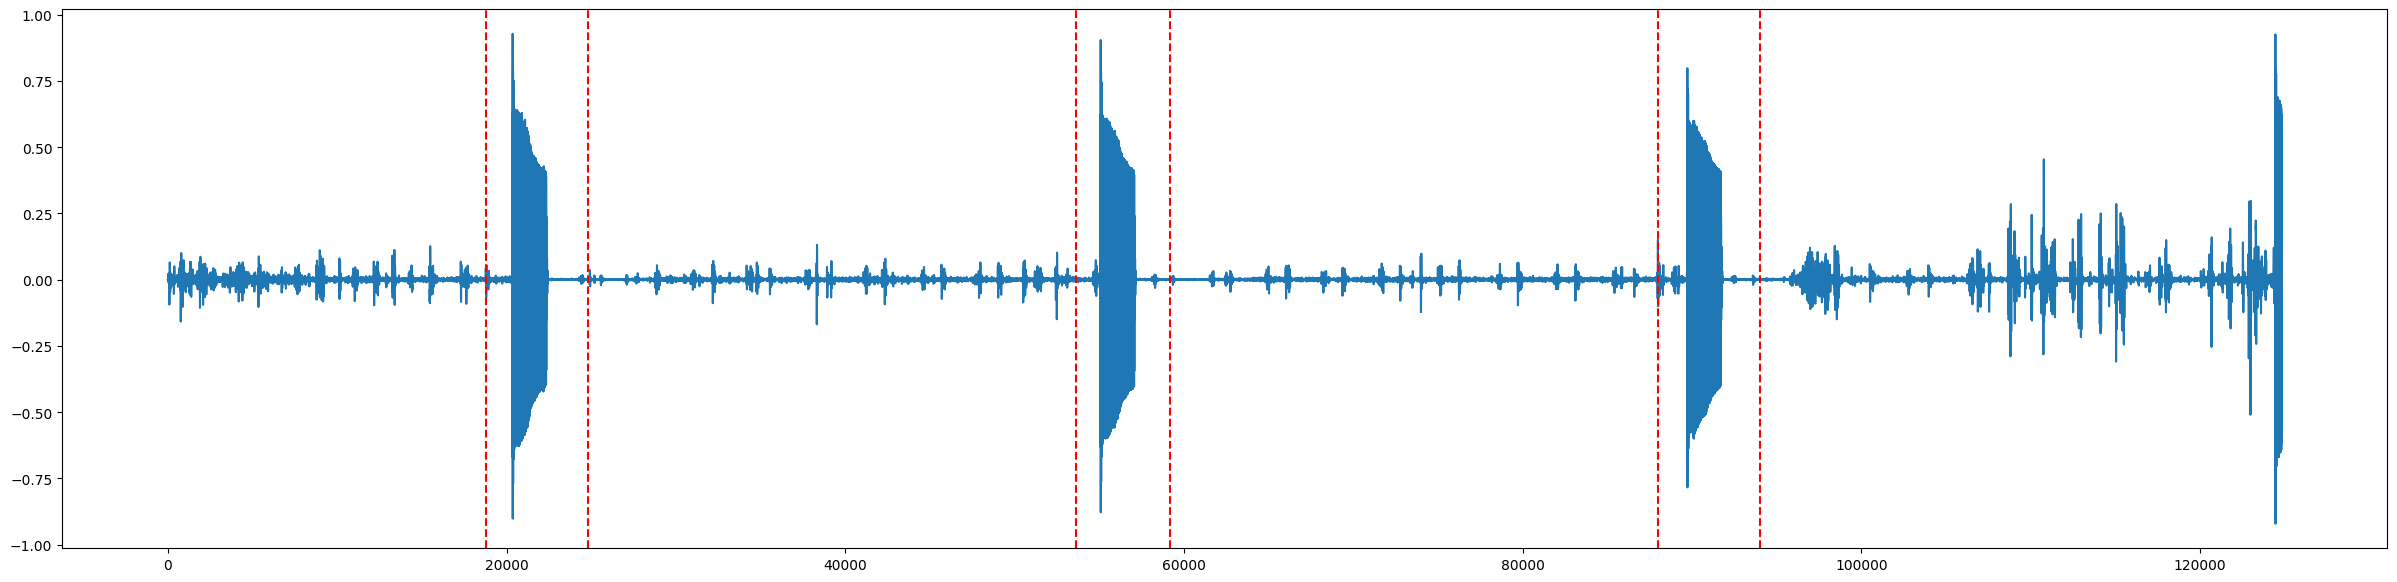

In [9]:
upsampled_peaks = peaks * DOWNSAMPLE_FACTOR
print(f"Peaks found in downsampled signal: {peaks}")
print(f"Peaks in real signal: {upsampled_peaks}")

plt.figure(figsize=(30, 7))
plt.plot(audio.squeeze())

for peak in upsampled_peaks:
    plt.axvline(x=peak, color="red", linestyle="--")

plt.show()

# All wrapped in one function

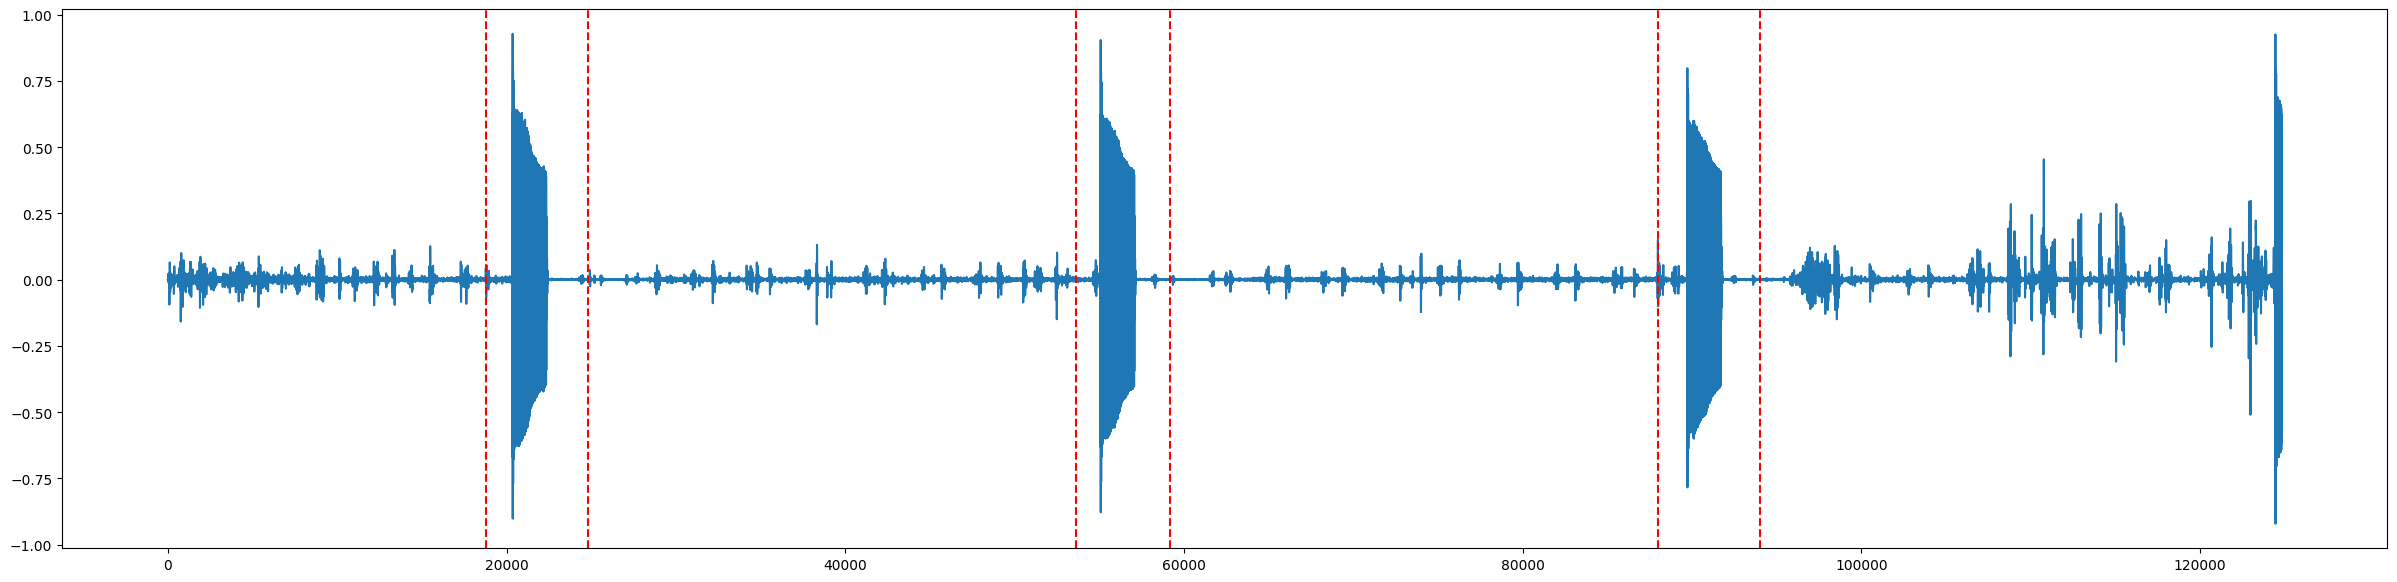

In [12]:
from helpers.find_trigger import FindTrigger

ft = FindTrigger()

trigger_peaks = ft.find_trigger_peaks(
    audio=audio,
    sample_rate=sample_rate,
    synthetic_freq=SYNTHETIC_FREQ,
    downsample_factor=DOWNSAMPLE_FACTOR,
    sigma_smooth=SIGMA_SMOOTH,
    peaks_height=PEAKS_HEIGHT,
    peaks_prominence=PEAKS_PROMINENCE,
)

plt.figure(figsize=(30, 7))
plt.plot(audio.squeeze())

for peak in trigger_peaks:
    plt.axvline(x=peak, color="red", linestyle="--")

plt.show()